# Actividad Guiada 1. Machine Learning.
## Predicción de casos del Dengue. Análisis exploratorio.
##### Autor: Arturo Martínez Perona

Vamos a utilizar los datos de la competición de predicción de los datos del Dengue. 

El objetivo es realizar un análisis exploratorio de los datos con técnicas de aprendizaje no supervisado, seleccionar características, tratar outliers, etc.

### Carga de datos y librerías

Primero vamos a cargar las librerías básicas

In [1]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

Ahora utilizamos las funcionalidades de Google Colab para cargar los datos. Para ello definimos una función que retorne el dataset leido por pandas. Después creamos el objeto utilizando esa función.

In [2]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

In [3]:
train = upload_files(['city', 'weekofyear', 'year'])
train.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


week_start_date  ...  station_precip_mm
city weekofyear year                  ...                   
sj   18         1990      1990-04-30  ...               16.0
     19         1990      1990-05-07  ...                8.6
     20         1990      1990-05-14  ...               41.4
     21         1990      1990-05-21  ...                4.0
     22         1990      1990-05-28  ...                5.8

[5 rows x 21 columns]

A destacar que las variables 'city', 'weekofyear' y 'year' se han cargado en el dataset conjuntamente como un índice, en parte esta es una forma bastante cómoda de trabajar y deja fuera del análisis a las variables no numéricas, aunque otra estrategia habría sido utilizar la función de preprocessing de la libreria de sklearn: LabelBinzarized(), que nos binarizaría las variables categóricas en una numérica discreta.

### Análisis exploratorio


Ahora vamos a investigar un poco en el dataset para averiguar si tenemos _missing values_ o muchos outliers. También investigaremos las variables para hacer las transformaciones necesarias para poder aplicar correctamente los algoritmos de _clustering_. 

In [4]:
train.shape

(1456, 21)

In [49]:
train.dtypes

ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm                        float64
dtype: object

In [5]:
train.isnull().sum()

week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

Como vemos hay una buena cantidad de _nulls_ en el dataset de los que nos tenemos que encargar. Especialmente vemos que las variables de vegetación ndvi tienen una cantidad bastante alta, y esto ya nos da una pista de que va a ser una variable delicada de tratar. Una estrategia para lidiar con esto es rellenarlos con el valor previo, el _metodo ffill_.

In [6]:
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

Una vez nos hemos encargado de los _missing values_ es hora de que investiguemos sobre como se distribuyen las variables

In [7]:
train.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,0.131271,0.128068,0.202606,0.201987,45.686937,298.697965,299.221483,295.245445,303.419505,295.719712,40.111635,82.176203,45.686937,16.745565,4.898656,27.180313,8.085646,32.443338,22.099863,39.194162
std,0.138527,0.119561,0.074409,0.083592,43.779318,1.361950,1.262676,1.527527,3.233030,2.559398,43.329174,7.161016,43.779318,1.542276,3.542340,1.280861,2.122836,1.960769,1.569113,47.363305
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,0.039100,0.048250,0.152795,0.144455,9.655000,297.654643,298.257143,294.119643,301.000000,293.900000,13.085000,77.185714,9.655000,15.560000,2.328571,26.300000,6.528571,31.100000,21.100000,8.700000
50%,0.113900,0.115926,0.195664,0.190121,38.235000,298.646429,299.285714,295.639286,302.400000,296.200000,27.245000,80.301429,38.235000,17.087143,2.857143,27.400000,7.364286,32.800000,22.200000,23.800000
75%,0.232018,0.213429,0.247461,0.246775,70.227500,299.827500,300.207143,296.460000,305.500000,297.900000,52.200000,86.406429,70.227500,17.977500,7.617857,28.132143,9.600000,33.900000,23.300000,53.675000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


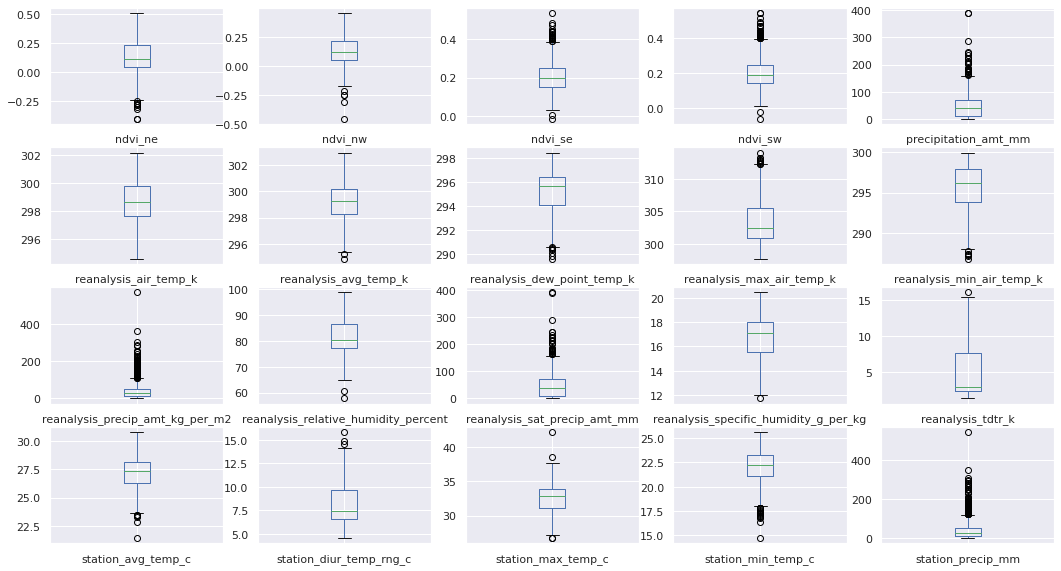

In [44]:
# Box and Whisker Plots

train.plot(kind='box', subplots=True, layout=(6,5), sharex=False, sharey=False, figsize=(18,15))
plt.show()

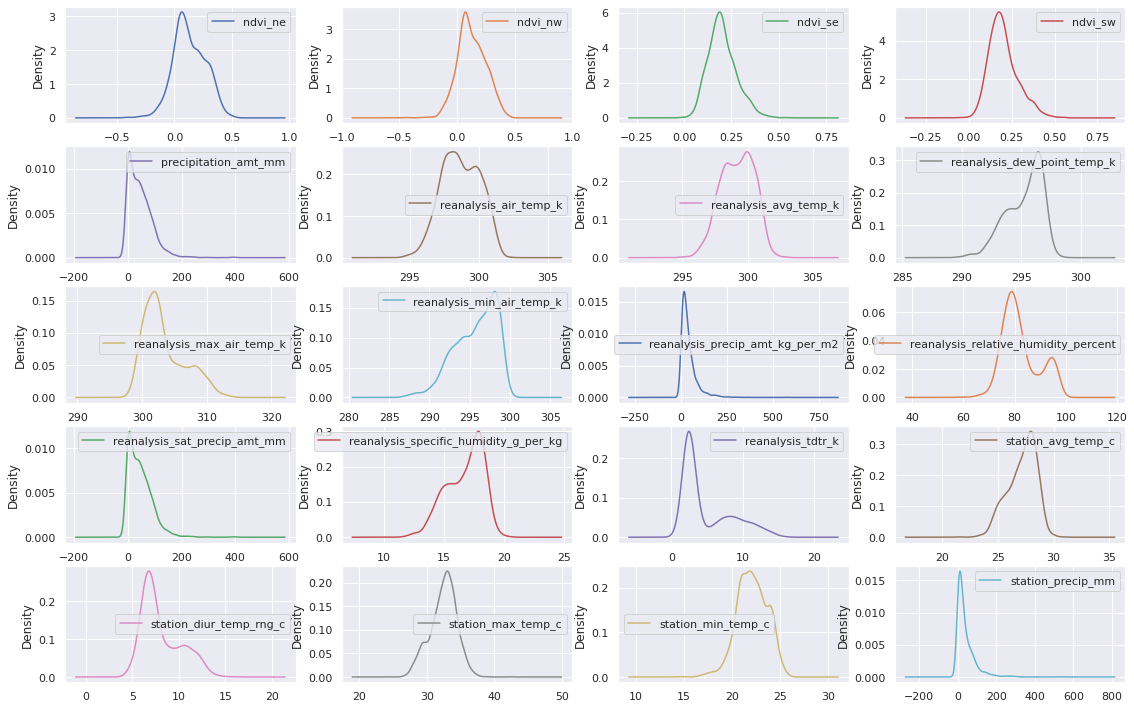

In [48]:
## Density plots

train.plot(kind='density', subplots=True, layout=(6,4), sharex=False,figsize=(19,15))
plt.show()

Cómo vemos, existen numerosos ouliers en el dataset repartidos entre las variables. Sin embargo, puesto que este dataset es una serie temporal, eliminar datos podría ser contraproducente. 
Además, la distribución de algunas de las variables no es una normal. Pero esto ocurre en las variables relacionadas con las precipitaciones, lo cual es lógico, ya que el mínimo de precipitaciones solo puede ser cero y lo normal es que éste ser el valor más repetido y vaya cayendo la probabilidad, siendo muy raras las semanas en que ha llovido en gran cantidad. Esto concuerda con el hecho de que el Dengue es una enfermedad asociada a climas tropicales (Murray et al. 2013) que se caracterizan por las lluvias estacionales (Lau and Wu, 2007)

#### Selección de características

Cómo vemos, el dataset tiene más de 20 variables. Atendiendo a la información proporcionada en DrivenData (https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/) tenemos medidas sobre temperatura, precipitaciones y humedad de diferentes fuentes y escalas. Por otro lado, tenemos indicadores de vegetación de la ciudad, que se basan en el índice NDVI, que es un indice que normaliza la vegetación en base al espectro de radiación electromagnética. 
En este sentido, es de esperar que exista una alta correlación entre grupos de variables, por lo que podemos hacer una selección de características que reduzca la dimensionalidad de los datos.



In [9]:
train = train.drop(["week_start_date"], axis = 1)
train.head()

ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
city weekofyear year                      ...                                       
sj   18         1990  0.122600  0.103725  ...                20.0               16.0
     19         1990  0.169900  0.142175  ...                22.2                8.6
     20         1990  0.032250  0.172967  ...                22.8               41.4
     21         1990  0.128633  0.245067  ...                23.3                4.0
     22         1990  0.196200  0.262200  ...                23.9                5.8

[5 rows x 20 columns]

In [10]:
from numpy import corrcoef, transpose, arange

train_feat = transpose(train)
train_feat

city                                           sj  ...          iq
weekofyear                                     18  ...          25
year                                         1990  ...        2010
ndvi_ne                                  0.122600  ...    0.298186
ndvi_nw                                  0.103725  ...    0.232971
ndvi_se                                  0.198483  ...    0.274214
ndvi_sw                                  0.177617  ...    0.315757
precipitation_amt_mm                    12.420000  ...   63.220000
reanalysis_air_temp_k                  297.572857  ...  298.097143
reanalysis_avg_temp_k                  297.742857  ...  299.835714
reanalysis_dew_point_temp_k            292.414286  ...  295.807143
reanalysis_max_air_temp_k              299.800000  ...  307.800000
reanalysis_min_air_temp_k              295.900000  ...  292.300000
reanalysis_precip_amt_kg_per_m2         32.000000  ...   36.900000
reanalysis_relative_humidity_percent    73.365714  ...   89.082857
reanalysis_sat_precip_amt_mm            12.420000  ...   63.220000
reanalysis_specific_humidity_g_per_kg   14.012857  ...   17.355714
reanalysis_tdtr_k                        2.628571  ...   11.014286
station_avg_temp_c                      25.442857  ...   27.475000
station_diur_temp_rng_c                  6.900000  ...    9.900000
station_max_temp_c                      29.400000  ...   33.700000
station_min_temp_c                      20.000000  ...   22.200000
station_precip_mm                       16.000000  ...   20.400000

[20 rows x 1456 columns]

In [11]:
names = train_feat.index
names

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

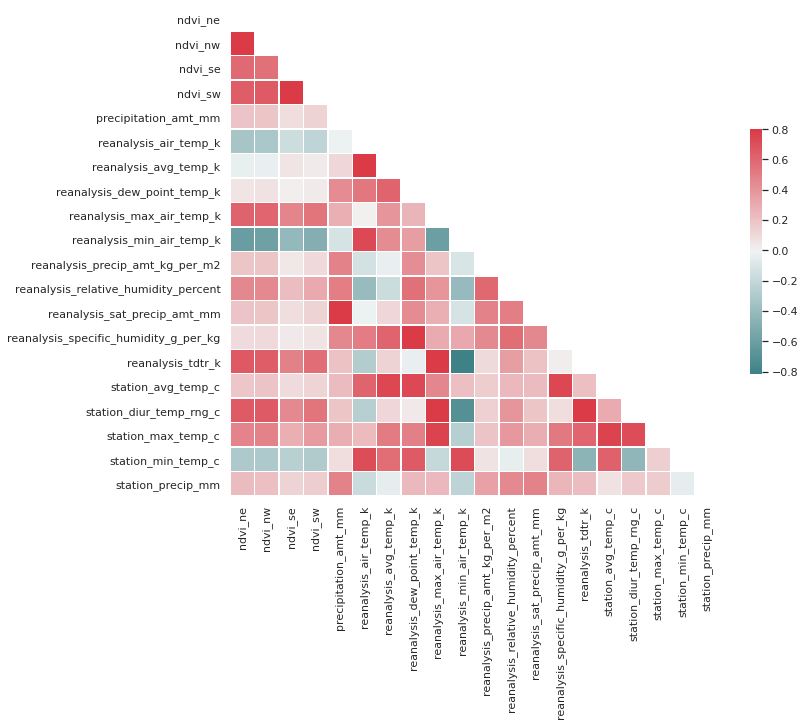

In [12]:

R = corrcoef(train_feat)

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

En la matriz de correlación ya observamos como existen correlaciones de en torno a (-0.8,0.8) en diversas variables. 
Por tanto, para hacer una selección fina de las variables, vamos a utilizar el algoritmo de DBSCAN, capaz de localizar outliers, o en este caso, variables que son diferentes a las demás, así como agrupar las parecidas.

De este modo, primero procedemos a una normalización de los datos, y hacemos una representación PCA de las variables, así vemos gráficamente como están relacionadas.

Variance Ratio:  [0.97883602 0.01292526]


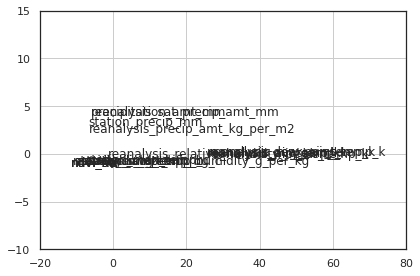

In [13]:
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(train_feat)
# Principal Component Analysis
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(features_norm)
print("Variance Ratio: ", estimator.explained_variance_ratio_) 


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], names[i]) 

plt.xlim(-20, 80)
plt.ylim(-10, 15)
ax.grid(True)
fig.tight_layout()
plt.show()


A simple vista podríamos identificar que existen dos grupos. Así mismo, el eje X representa el 98% de la variabilidad.

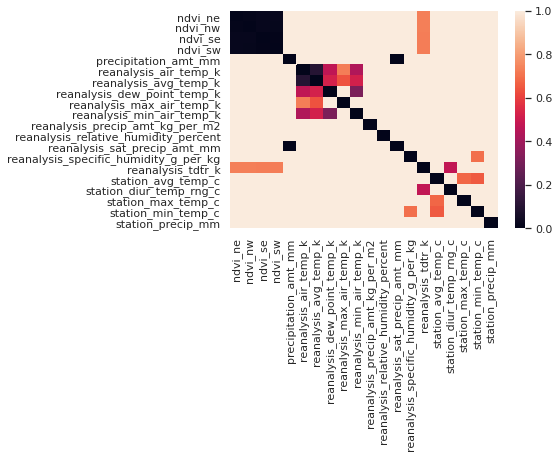

In [14]:
from scipy import cluster
import sklearn.neighbors
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(features_norm)


# Visualizamos la matriz de distancias.
import seaborn as sns; sns.set()
ax = sns.heatmap(matdist,vmin=0, vmax=1, yticklabels = names, xticklabels = names)

Visualizando la matriz de distancias se aprecian cosas interesantes. En primer lugar, las variables NDVI son totalmente cercanas. Estas variables representan cada una de ellas un píxel cardinal de vegetación de la ciudad. Luego, el resto de variables en principio no estan estrechamente relacionadas, excepto por algunas que forman grupos, como las de temperatura entre ellas.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


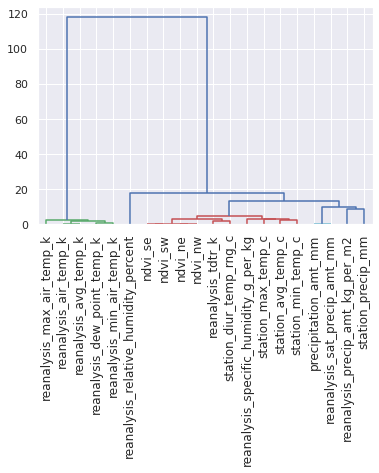

In [15]:
clusters = cluster.hierarchy.linkage(matdist, method = 'single')
cluster.hierarchy.dendrogram(clusters, color_threshold = 6, labels = names , leaf_rotation=90)
plt.show()

Ahora vamos a elegir un _epsilon_ para la parametrización del algoritmo de DBSCAN

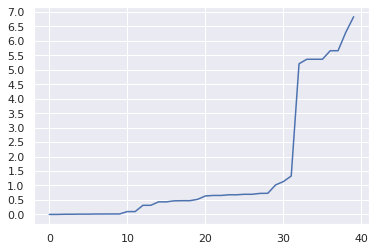

In [16]:
minPts=2
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(features_norm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(features_norm):
    for j in range(len(features_norm)):
        if Ar[i][j] != 0:
            seq.append(matdist[i][j])
            
seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 120, 10))
ax.set_yticks(np.arange(0, 10, 0.5))

plt.plot(seq)


plt.show()

Parece que existe un gran codo alrededor de 1.3 - 1.5

In [17]:
from sklearn.cluster import DBSCAN

for eps in np.arange(0.50, 6, 0.5):
  db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  0.50, 4, 8
  1.00, 4, 3
  1.50, 3, 3
  2.00, 3, 3
  2.50, 3, 3
  3.00, 3, 3
  3.50, 3, 3
  4.00, 3, 3
  4.50, 3, 3
  5.00, 3, 3
  5.50, 2, 2


Entonces vamos a aplicar DBSCAN con una _epsilon_ = 1.5

In [18]:
db = DBSCAN(eps=1.5, min_samples=minPts).fit(features_norm)
labels = db.labels_
labels

array([ 0,  0,  0,  0,  1,  2,  2,  2,  2,  2, -1, -1,  1,  0,  0,  0,  0,
        0,  0, -1])

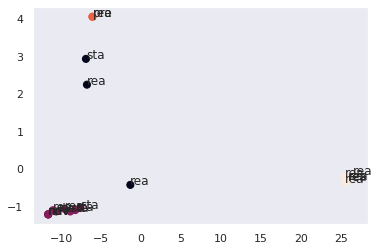

In [19]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], names[i][0:3]) 
plt.grid()
plt.show()

De manera que finalmente vemos que tenemos 3 grupos diferenciados, además de otras tres variables totalmente diferentes a todas las demás. Utilizaremos, entonces, esas tres variables, y una representante de los otros grupos como variables definitivas.

In [20]:
train_feat['dbscan_group'] = labels

train_feat[train_feat['dbscan_group'] == -1]


city                                         sj  ... dbscan_group
weekofyear                                   18  ...             
year                                       1990  ...             
reanalysis_precip_amt_kg_per_m2       32.000000  ...           -1
reanalysis_relative_humidity_percent  73.365714  ...           -1
station_precip_mm                     16.000000  ...           -1

[3 rows x 1457 columns]

In [37]:
train_feat1 = transpose(train_feat[train_feat['dbscan_group'] == -1])


In [22]:
train_feat2 = transpose(train_feat[train_feat['dbscan_group'] == 0])
list(train_feat2.columns)

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c']

Vamos a escoger del grupo 0 de variables una de las variables que aportan información sobre temperatura, ya que no tenemos otra variable de temperatura entre los seleccionados. Además, si recordamos, por lo que respecta a las variables ndvi, éstas tenian muchos null, y hubo que rellenar bastantes datos.

In [38]:
train_feat1['station_avg_temp_c'] = train_feat2['station_avg_temp_c']
train_feat1.head()

reanalysis_precip_amt_kg_per_m2  ...  station_avg_temp_c
city weekofyear year                                   ...                    
sj   18         1990                            32.00  ...           25.442857
     19         1990                            17.94  ...           26.714286
     20         1990                            26.10  ...           26.714286
     21         1990                            13.90  ...           27.471429
     22         1990                            12.20  ...           28.942857

[5 rows x 4 columns]

In [24]:
train_feat3 = transpose(train_feat[train_feat['dbscan_group'] == 1])
list(train_feat3.columns)

['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm']

In [39]:
train_feat1['precipitation_amt_mm'] = train_feat3['precipitation_amt_mm']
train_feat1.head()

reanalysis_precip_amt_kg_per_m2  ...  precipitation_amt_mm
city weekofyear year                                   ...                      
sj   18         1990                            32.00  ...                 12.42
     19         1990                            17.94  ...                 22.82
     20         1990                            26.10  ...                 34.54
     21         1990                            13.90  ...                 15.36
     22         1990                            12.20  ...                  7.52

[5 rows x 5 columns]

In [40]:
train_feat1.dtypes

reanalysis_precip_amt_kg_per_m2         float64
reanalysis_relative_humidity_percent    float64
station_precip_mm                       float64
station_avg_temp_c                      float64
precipitation_amt_mm                    float64
dtype: object

De manera que tras trabajar un poco con el dataset, estas son las características finales con las que contaremos en el análisis.


#### Clustering de datos

Una vez seleccionadas las características con las que vamos a trabajar, podemos investigar un poco, de manera prematura sobre los datos, con métodos de aprendizaje no supervisado

Pero antes de aplicarlos vamos a hacer una normalización de los datos entre 0 y 1, ya que vamos a usar métodos basados en distancias.

In [63]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_feat1)
X_train

array([[0.05774278, 0.74656876, 0.03123278, 0.82606679, 0.03179724],
       [0.03314086, 0.78675406, 0.01763733, 0.86734694, 0.05842294],
       [0.04741907, 0.83378031, 0.07789822, 0.86734694, 0.08842806],
       ...,
       [0.11081365, 0.96034535, 0.03123278, 0.82575758, 0.15276498],
       [0.06631671, 0.90435556, 0.03931655, 0.89204545, 0.16185356],
       [0.        , 0.        , 0.        , 0.        , 0.00256016]])

Vamos a probar con un k-means, para ello, primero deberíamos encontrar cuántos clusteres se pueden encontrar en nuestro datos.

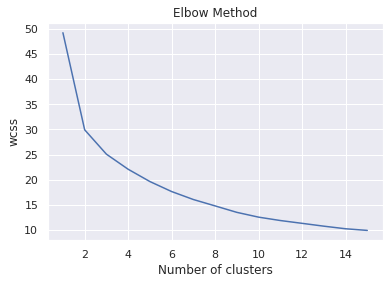

In [64]:
from sklearn.cluster import KMeans

wcss = []

for i in range (1,16): #15 cluster
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=0) 
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,16),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()



Parece que el codo se encuentra en el 2, ya que es donde se produce el cambio más importante

In [76]:
#KMeans clustering
kmeans= KMeans(n_clusters=2,init='k-means++', random_state=0)
y=kmeans.fit_predict(X_train)
train_feat1['cluster'] = y
train_feat1.head()

reanalysis_precip_amt_kg_per_m2  ...  cluster
city weekofyear year                                   ...         
sj   18         1990                            32.00  ...        0
     19         1990                            17.94  ...        0
     20         1990                            26.10  ...        0
     21         1990                            13.90  ...        0
     22         1990                            12.20  ...        0

[5 rows x 6 columns]

Otra manera interesante, para poder representarlo, es hacer previamente una PCA, de manera que reducimos las dimensiones

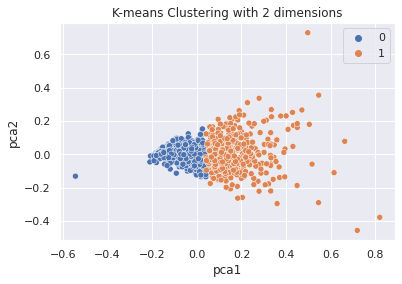

In [77]:

### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(X_train)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

Como vemos, esto lo hace el k-means un poco a grosso modo, dejando puntos que parecen claramente outliers dentro de los grupos. Sería interesante utilizar entonces el DBSCAN que es capaz de caracterizar bien los outliers.

In [91]:
for eps in np.arange(0.01, 0.2, 0.01):
  db = DBSCAN(eps, min_samples=4).fit(reduced_data)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  0.01, 21, 287
  0.02, 5, 108
  0.03, 4, 56
  0.04, 3, 38
  0.05, 2, 23
  0.06, 2, 15
  0.07, 1, 13
  0.08, 1, 10
  0.09, 1, 9
  0.10, 1, 9
  0.11, 1, 9
  0.12, 1, 8
  0.13, 1, 8
  0.14, 1, 7
  0.15, 1, 5
  0.16, 1, 5
  0.17, 1, 5
  0.18, 1, 5
  0.19, 1, 4


Parece que 0.05 nos da 2 clases, y nos localiza 23 outliers.

In [93]:
db = DBSCAN(eps=0.05, min_samples=4).fit(reduced_data)
labels = db.labels_
labels

array([ 0,  0,  0, ...,  0,  0, -1])

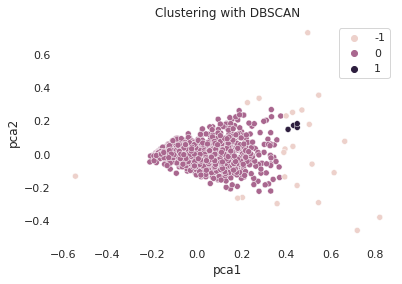

In [96]:
sns.scatterplot(x="pca1", y="pca2", hue=labels, data=results)
plt.title('Clustering with DBSCAN')
plt.grid()
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

Finalmente vemos que nos localiza una clase que es casi toda la nube de puntos, otro pequeño grupo de 4 puntos, y el resto son outliers. Sin duda parece que agrupa mejor los datos que el K-means, pero estos métodos no parecen de todo efectivos para usarlos como predictores de casos del dengue, aun así nos dejan una buena base de descripción de los datos para poder continuar con la AG2 donde aplicaremos métodos de predicción vistas en la asignatura

### Referencias

Lau, K. M., & Wu, H. T. (2007). Detecting trends in tropical rainfall characteristics, 1979–2003. International Journal of Climatology: A Journal of the Royal Meteorological Society, 27(8), 979-988.

Murray, N. E. A., Quam, M. B., & Wilder-Smith, A. (2013). Epidemiology of dengue: past, present and future prospects. Clinical epidemiology, 5, 299.